In [1]:
#!pip install opencv-python

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
import tensorflow as tf

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
import cv2
import glob

# data pre-processing

In [5]:
# function is to retrieve image id from the file path
def get_image_id(file_path):
    image_id = file_path.split('/')[-1].replace('.jpg','')
    return image_id

In [6]:
# test the above function out
get_image_id('./train/000bec180eb18c7604dcecc8fe0dba07.jpg')

'000bec180eb18c7604dcecc8fe0dba07'

In [7]:
# the function is to load the image files from the local directory
def load_images(path):
    images = []
    gray_images = []
    image_ids = []

    for file in glob.glob(path):
        image_ids.append(get_image_id(file))
        #load image to rgb
        raw_image  = cv2.imread(file)
        #resize
        resized_image = cv2.resize(raw_image, (224, 224)) 
        #rgb to gray
        grayimage = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        gray_images.append(grayimage)
        images.append(resized_image)
    # we got list here, but return array for easy manipulation later
    return np.array(images), np.array(gray_images), np.array(image_ids)

In [8]:
test_images, test_gray_images,test_image_ids = load_images('./test/*.jpg')

In [9]:
train_images, train_gray_images, train_image_ids = load_images('./train/*.jpg')

In [10]:
test_image_ids[0:3]

array(['fd1a7be32f10493735555e62913c0841',
       '5273d42f02b4715cb93845205995ef64',
       '442057a3142f4d75a1023db363e2fb54'],
      dtype='<U32')

In [11]:
train_image_ids[0:3]

array(['377c941b6884717dfb825cfe1a11856a',
       '36b5e85c07a980914b311163b9f87404',
       '98b6235a39ffbd772524aae2c4e1b3ab'],
      dtype='<U32')

In [12]:
def display_img(single_img):
    bgr_img = single_img
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)

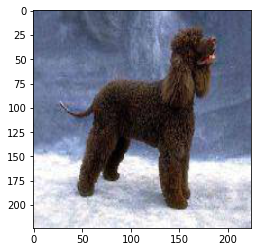

In [13]:
display_img(test_images[0])

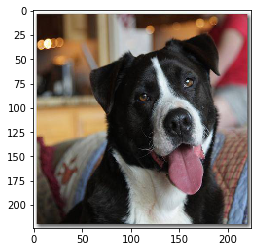

In [14]:
display_img(train_images[0])


train  image shape is (10222, 224, 224, 3)
test image shape is (10357, 224, 224, 3)
train gray image shape is (10222, 224, 224)
test gray image shape is (10357, 224, 224)


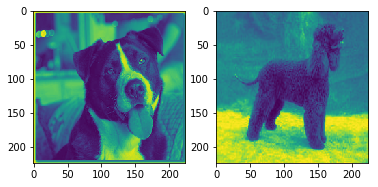

In [15]:
print('train  image shape is {}'.format(train_images.shape))
print('test image shape is {}'.format(test_images.shape))
print('train gray image shape is {}'.format(train_gray_images.shape))
print('test gray image shape is {}'.format(test_gray_images.shape))
plt.figure(figsize=(6, 4))
f, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(train_gray_images[0])
ax[1].imshow(test_gray_images[0])

In [16]:
train_raw_labels = pd.read_csv("labels.csv")
train_raw_labels.shape


(10222, 2)

In [17]:
# since we are not sure if labels.csv is matching to our image list here
# use the train_image_ids and train_raw_labels to get the train_labels
image_id_df = pd.DataFrame(train_image_ids, columns=['id'])
image_id_df.head(4)


,id
0,377c941b6884717dfb825cfe1a11856a
1,36b5e85c07a980914b311163b9f87404
2,98b6235a39ffbd772524aae2c4e1b3ab
3,11bbd6229f14cc68bd0f157a9ef1d47d


In [18]:
print(train_raw_labels.head(4))
print(image_id_df.head(4))
image_labels_df = pd.merge(image_id_df,train_raw_labels, on='id')
print(image_labels_df.head(4))

                                 id        breed
0  000bec180eb18c7604dcecc8fe0dba07  boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97        dingo
2  001cdf01b096e06d78e9e5112d419397     pekinese
3  00214f311d5d2247d5dfe4fe24b2303d     bluetick
                                 id
0  377c941b6884717dfb825cfe1a11856a
1  36b5e85c07a980914b311163b9f87404
2  98b6235a39ffbd772524aae2c4e1b3ab
3  11bbd6229f14cc68bd0f157a9ef1d47d
                                 id             breed
0  377c941b6884717dfb825cfe1a11856a     border_collie
1  36b5e85c07a980914b311163b9f87404       appenzeller
2  98b6235a39ffbd772524aae2c4e1b3ab  mexican_hairless
3  11bbd6229f14cc68bd0f157a9ef1d47d           redbone


#### onehot encoding labels

In [19]:
train_labels_total = pd.DataFrame(image_labels_df['breed'], columns=['breed'])
# then we apply one hot encoder
train_labels_onehot = pd.get_dummies(train_labels_total)
# train_images is list, change to array in order to use shape()
print( 'Train data:{}, Train labels:{}, Train onehot labels: {}'.format(
    np.array(train_images).shape, train_labels_total.shape, train_labels_onehot.shape ))


Train data:(10222, 224, 224, 3), Train labels:(10222, 1), Train onehot labels: (10222, 120)


there are 120 unique species in training data
the frequency distribution of breed in training data is:


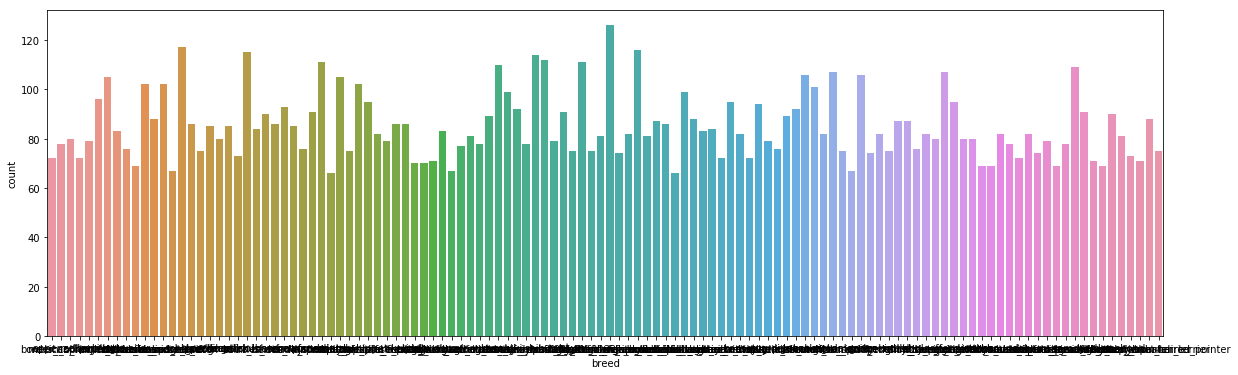

In [20]:
import seaborn as sns
print('there are {} unique species in training data'.format(len(train_labels_total['breed'].unique())))
f, ax = plt.subplots(figsize=(20, 6))
print('the frequency distribution of breed in training data is:')
sns.countplot( x= 'breed',data=image_labels_df);


#### set cross validation dataset

In [21]:
from sklearn.model_selection import train_test_split

# Take 1/3 images from the training data, and leave the remainder in training
train_data, valid_data, train_labels, valid_labels = train_test_split(train_images, train_labels_onehot, test_size=0.33, random_state=2016)
print('Training data: ', train_data.shape, train_labels.shape)
print('Validation data: ', valid_data.shape, valid_labels.shape)

Training data:  (6848, 224, 224, 3) (6848, 120)
Validation data:  (3374, 224, 224, 3) (3374, 120)


In [22]:
# the following is to get training set for grayed images
# one hot encode 
# Take 1/3 images from the training data, and leave the remainder in training
train_data_bw, valid_data_bw, train_labels_bw, valid_labels_bw = train_test_split(train_gray_images, train_labels_onehot, test_size=0.33, random_state=2016)
print('Training data: ', train_data_bw.shape, train_labels_bw.shape)
print('Validation data: ', valid_data_bw.shape, valid_labels_bw.shape)

Training data:  (6848, 224, 224) (6848, 120)
Validation data:  (3374, 224, 224) (3374, 120)


In [23]:
def plot_strip(data, labels):
    plt.rcParams['figure.figsize'] = (15.0, 15.0)
    f, ax = plt.subplots(nrows=1, ncols=5)

    for i, j in enumerate(np.random.randint(0,labels.shape[0], size=5)):
        ax[i].axis('off')
        # Note here: need to use labels.iloc[j,:]) instead of labels[j]
        # ax[i].set_title(labels.iloc[j][['breed']], loc='center')
        ax[i].set_title(labels[j], loc='center')
        ax[i].imshow(data[j,:,:], cmap='gray')



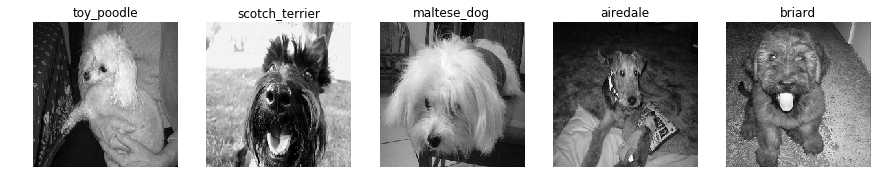

In [24]:
# label to match onehot labels: train_labels_total.iloc[train_labels_bw.index]['breed']        
plot_strip(train_data_bw, np.array(train_labels_total.iloc[train_labels_bw.index]['breed']))

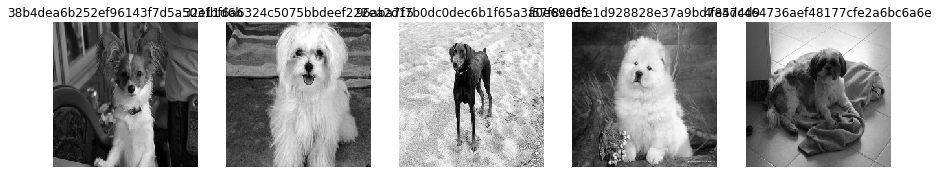

In [25]:
plot_strip(test_gray_images, test_image_ids)

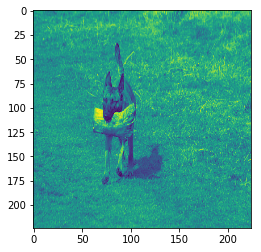

In [26]:
# the following is another way to get grayed images, however we r going to use the opencv's approach
# Create a lambda function to turn the images to grayscale - just a dot product
# see http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf
rgb2gray = lambda rgb:  np.dot(rgb.astype(float), [[0.2989],[0.5870],[0.1140]])
test_gray = rgb2gray(train_data[0:2])[:,:,:,0]
plt.figure(figsize=(6, 4))
plt.imshow(test_gray[0])

In [27]:
# Create a normalization function that normalizes values bewtween -1 and 1 and with mean=0
def normalize_image(dataset, epsilon=1e-10):
    """ Normalization of black and white image"""
    
    mean = np.mean(dataset, axis=(1,2), dtype=np.float32)
    std = np.std(dataset, axis=(1,2), dtype=np.float32, ddof=1)
    std[std < epsilon] = epsilon
    for i in range(dataset.shape[0]):
        dataset[i,:,:] = (dataset[i,:,:] - mean[i]) / std[i]
        
    return dataset

train_data_bw = normalize_image(train_data_bw)
test_data_bw = normalize_image(test_gray_images)
valid_data_bw = normalize_image(valid_data_bw)

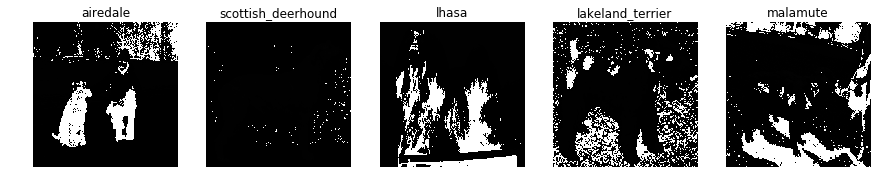

In [28]:
plot_strip(train_data_bw, np.array(train_labels_total.iloc[train_labels_bw.index]['breed']))

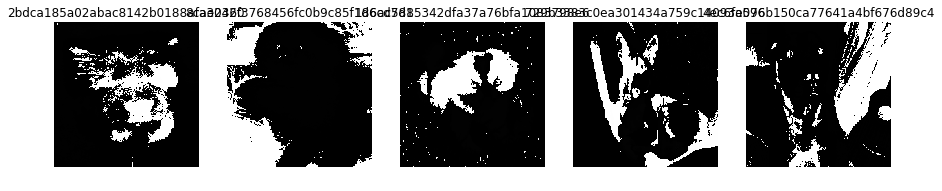

In [29]:
plot_strip(test_data_bw, test_image_ids)

In [ ]:
# use pickle to store data
# when we run on AWS, this segment is not necessary
pickle_file = 'IMAGE_BW.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_data': train_data_bw,
        'train_labels': train_labels_bw,
        'valid_data': valid_data_bw,
        'valid_labels': valid_labels_bw,
        'test_data': test_data_bw,
        #'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [39]:
# the following segment is for reloading data back
# when we run on AWS, this segment is not necessary
pickle_file = 'IMAGE_BW.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data_bw = save['train_data']
    train_labels_bw = save['train_labels']
    valid_data_bw = save['valid_data']
    valid_labels_bw = save['valid_labels']
    test_data_bw = save['test_data']
    #test_labels = save['test_labels']
    del save  # to free up memory
    
    print('Training set', train_data_bw.shape, train_labels_bw.shape)
    print('Validation set', valid_data_bw.shape, valid_labels_bw.shape)
    print('Test set', test_data_bw.shape)

Training set (6848, 224, 224) (6848, 120)
Validation set (3374, 224, 224) (3374, 120)
Test set (10357, 224, 224)


# Apply Dense NN

#### in this NN, we are using grayed normalized and flattened dataset

In [30]:
image_size = train_data_bw.shape[1]
num_labels = train_labels_bw.shape[1]
print('image size is {}'.format(image_size))
print('number of unique dog breed labels are {}'.format(num_labels))


image size is 224
number of unique dog breed labels are 120


In [31]:
# have trouble to make the following one hot encoder work for string label, these work for numeric labels
# Encode a n by 1 vector of k labels to a n by k matrix of one hot values
#one_hot_encode = lambda label_array, n_values: (np.arange(n_values) == label_array).astype(np.float32)
# Decode a n by k matrix of one hot values back to a n by 1 vector of k labels
one_hot_decode = lambda oh_labels: np.dot(oh_labels, np.expand_dims(np.arange(oh_labels.shape[1]), axis=1)).astype(int)

# reformat data -- flatten the dataset
def reformat(dataset):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    return dataset


In [32]:
# switch to categorical type for breed
#train_labels["breed_cat"] = train_labels['breed'].astype('category')
#valid_labels["breed_cat"] = valid_labels['breed'].astype('category')
train_dataset = reformat(train_data_bw)
valid_dataset = reformat(valid_data_bw)
test_dataset = reformat(test_data_bw)
print('Training set', train_dataset.shape, train_labels_bw.shape)
print('Validation set', valid_dataset.shape, valid_labels_bw.shape)
print('Test set', test_dataset.shape)

Training set (6848, 50176) (6848, 120)
Validation set (3374, 50176) (3374, 120)
Test set (10357, 50176)


### <a id='nn_hyperparameters'>Set neural network hyperparameters</a>
[back to run session](#run_session)

In [33]:
# for convenience, this section is copied to the code segment right above each session run.
# to keep this one here is just for learning purpose

# use learning rate decay technique, with the epoch progressing, adjust learning rate
start_learning_rate = 0.05
decay_steps = 100000 
decay_rate = 0.96

# for regularization
lamb_reg = 0.001 

# keep probability : how much relu results we should keep
# effect: slow down learning process for training, increase validation set accuracy
k_prob = 0.8 


num_epochs = 10
batch_size = 256
flattened_size = train_dataset.shape[1]
#### Set number of neurons for each layer
hidden_nodes = 1000


####  Define dictionaries for storing weights and biases for each layer -- and initialize

In [34]:

def weight_variable(shape, name):
    # got the problem with the very large loss, even loss value got overflow when I increase number of layers
    # np.sqrt(2.0/shape[0]) doesn't really help, have to make stddev really small
    initial = tf.truncated_normal(shape, stddev=1e-4)
    #initial = tf.truncated_normal(shape, stddev=np.sqrt(2.0/shape[0]))
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    #initial = tf.constant(0.1, shape=shape)
    initial = tf.zeros(shape)
    return tf.Variable(initial, name)

split_by_half = lambda x,k : int(x/2**k)

#### Build model

In [35]:
#predictions = network(x, weights=weight_dict, biases=bias_dict, name = 'logits')
# Model with dropout
def model(data, name, proba):
    with tf.name_scope(name) as scope:
        # linear output layer (softmax)
        layer1 = tf.add(tf.matmul(data, layer1_weights), layer1_biases, name="layer1")
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba, name="dropout1")   # dropout on the hidden layer
        # linear output layer (softmax)
        layer2 = tf.add(tf.matmul(hidden1, layer2_weights), layer2_biases, name="layer2")
        return layer2

In [36]:
# is to calculate the multiple layer regularization
def cal_regularization(layer_cnt):
    regularizers = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) 
    regularizers = regularizers + tf.nn.l2_loss(last_weights) + tf.nn.l2_loss(last_biases)
    for i in range(layer_cnt - 2):
        regularizers = regularizers + tf.nn.l2_loss(weights[i]) + tf.nn.l2_loss(biases[i]) 
    return regularizers

In [37]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

####  Define model's loss and its optimizer

In [38]:
def get_loss(logits, labels):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = labels), name="loss")
    return loss
# the following function is to get optimizer
# by default choice == 1, returns GradientDescentOptimizer
# choice == 2 , return AdamOptimizer
# choice == 3 , return MomentumOptimizer
def get_optimizer(learning_rate, loss, global_step, choice = 1):
    if choice == 2:
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    elif choice == 3:    
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss, global_step=global_step)
    else:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    return optimizer


#### Define evaluation metrics

In [39]:
# calculate accuracy by identifying test cases where the model's highest-probability class matches the true y label: 
def accuracy(predictions, labels):
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy_pct = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) * 100.0
    #another way to calculate this is to use np like following
    #return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])
    return accuracy_pct.eval()
    



#### Build Tensorflow graph

- ##### the following graph is two layer nn

In [40]:
n_classes = 120

In [41]:
graph = tf.Graph()
with graph.as_default():
    #### Define placeholders Tensors for inputs and labels
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, flattened_size), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, shape=(batch_size, n_classes), name="TrainingLabels")
    tf_valid_dataset = tf.constant(valid_dataset, name="ValidationData")
    # test dataset couldn't be tf.constant, since it's too big
    tf_test_dataset = tf.placeholder(tf.float32,shape=(None, flattened_size), name="TestingData")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([flattened_size, hidden_nodes]), name="weights1")
    layer1_biases = tf.Variable(tf.zeros([hidden_nodes]), name="biases1")
    layer2_weights = tf.Variable(tf.truncated_normal([hidden_nodes, n_classes]), name="weights2")
    layer2_biases = tf.Variable(tf.zeros([n_classes]), name="biases2")
        
    keep_prob = tf.placeholder("float", name="keep_prob")
        
    ####  Define model's loss and its optimizer
    # Training computation.
    logits = model(tf_train_dataset, "logits", keep_prob)
    loss = get_loss(logits, tf_train_labelset)
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labelset), name="loss")
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + 
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases))
    # Add the regularization term to the loss.
    loss += lamb_reg * regularizers

    # learning rate decay
    global_step = tf.Variable(0, name="globalstep")  # count number of steps taken.    
    #tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name=None)
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, decay_steps, decay_rate, staircase=True)
    # Passing global_step to minimize() will increment it at each step.
    optimizer = get_optimizer(learning_rate, loss, global_step)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, "validation", 1.0))  # no dropout
    test_prediction = tf.nn.softmax(model(tf_test_dataset, "testing", 1.0))  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

#### Train the network in a session

In [42]:
#  Code taken from #Hands-on Machine Learning book

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [43]:
def run_session(cur_graph, num_epochs, name, k_prob=1.0):

    with tf.Session(graph=cur_graph) as session:
        
        #### Create op for variable initialization
        #initializer_op = tf.global_variables_initializer()         
        #session.run(initializer_op)
        # another way to run the initialization
        tf.global_variables_initializer().run()
        
        #### save data into tensorboard
        loss_summary = tf.summary.scalar('Loss', loss)
        learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
        merged = tf.summary.merge_all()  
        writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)

        print("Training for", num_epochs, "epochs.")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels_bw.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            # train_labels is df , so switch to np.array
            batch_labels = np.array(train_labels_bw)[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels,
                         keep_prob : k_prob, tf_test_dataset : test_dataset }
            
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
            writer.add_summary(learning_rate_summary.eval(), epoch)
            
            # we use num_epochs < 10 to do the test run in local machine      
            if ( (epoch % 2000 == 0 and num_epochs != 10) or 
                (epoch < 5 and num_epochs <= 10)):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                mini_accuracy = accuracy(predictions, batch_labels)
                print("Minibatch accuracy: {:.1f}".format(mini_accuracy))
                valid_accuracy = accuracy(valid_prediction.eval(), np.array(valid_labels_bw))
                print("Validation accuracy: {:.1f}\n".format(valid_accuracy))
                #train_accuracy_summary = tf.summary.scalar('Train_Accuracy',mini_accuracy)
                #valid_accuracy_summary = tf.summary.scalar('Validation_Accuracy',valid_accuracy)
                #writer.add_summary(train_accuracy_summary.eval(), epoch)
                #writer.add_summary(valid_accuracy_summary.eval(), epoch)

        test_preds = pd.DataFrame(test_prediction.eval(feed_dict=feed_dict).ravel(), columns=['ravel_col'])
        test_preds.to_csv('/tmp/test_results.csv')
        print("test prediction result is saved in the file")    
        save_path = saver.save(session, "/tmp/" + name +".ckpt")
        print("Model saved in file: %s" % save_path)
        

- ##### the following graph is multiple layer ( layer number is input param) nn

In [44]:
# The function here is the general one to build up the flexible multi-layer dense NN and run the model to get results
# varibles takes in are 
# function input params: 
#    regular: if we include regularization in the model
#    layer_cnt: number of hidden layers
#    start_learning_rate: the learning rate we starts with
#  parameters defined in the notebook session:
#    lamb_reg: regularization rate
#    k_prob: keep probability
#    num_epochs: number of epochs to run
#    batch_size: batch size to be used in model
#    hidden_nodes: number of hidden_nodes in the first layer
#    opt_choice: choice for optimizer: GradientDescent, Adam, Momentum
   
def tf_deep_nn(name, regular = True, layer_cnt=2, start_learning_rate = 0.05):
    graph1 = tf.Graph()
    with graph1.as_default():
        print("model layer is {}".format(layer_cnt))
        print("hidden node number is {}".format(hidden_nodes))
        print("start_learning_rate is {}".format(start_learning_rate ))
        print("regularization is {} and parameter is {}".format(regular, lamb_reg ))
        print("drop out parameter is {}".format(k_prob ))
        print("run {} batch size".format(batch_size))
        if opt_choice == 2:
            print("optimizer is using AdamOptimizer")
        elif opt_choice == 3: 
            print("optimizer is using MomentumOptimizer")
        else:
            print("optimizer is using GradientDescentOptimizer")
        
        ####### Define placeholders Tensors for inputs and labels
        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, flattened_size), name="TrainingData")
        tf_train_labelset = tf.placeholder(tf.float32, shape=(batch_size, n_classes), name="TrainingLabels")
        tf_valid_dataset = tf.constant(valid_dataset, name="ValidationData")
        # test dataset couldn't be tf.constant, since it's too big
        tf_test_dataset = tf.placeholder(tf.float32,shape=(None, flattened_size), name="TestingData")

        ####### Variables.
        # start weight
        # stddev = np.sqrt(2.0 / n)
        layer1_weights = weight_variable([flattened_size, hidden_nodes], name="weights1")
        layer1_biases = bias_variable([hidden_nodes], name="biases1")

        # middle weight
        weights = []
        biases = []
        hidden_cur_cnt = hidden_nodes
        for i in range(layer_cnt - 2):
            if hidden_cur_cnt > 2:
                hidden_next_cnt = int(hidden_cur_cnt / 2)
            else:
                hidden_next_cnt = 2
            print("calculating {},{} and hidden_cur_cnt is {}".format("weights" + str(i),"biases" + str(i),hidden_cur_cnt ))
            mid_layer_weights = weight_variable([hidden_cur_cnt, hidden_next_cnt], name="weights" + str(i))
            mid_layer_biases = bias_variable([hidden_next_cnt], name="biases" + str(i))
            weights.append(mid_layer_weights)
            biases.append(mid_layer_biases)
            hidden_cur_cnt = hidden_next_cnt
        
        # last weights
        last_weights = weight_variable([hidden_cur_cnt, num_labels], name="weights_last")
        last_biases = bias_variable([num_labels], name="biases_last") 

        keep_prob = tf.placeholder("float", name="keep_prob")
        
        # put the model function in the graph to fix the "not in same graph" complain
        def nn_model_multi(data, layer_cnt, name, keep_prob):
            with tf.name_scope(name) as scope:

                ####### start modeling.
                # first wx + b
                layer1 = tf.add(tf.matmul(data, layer1_weights), layer1_biases, name="layer1")
                # first relu
                hidden = tf.nn.relu(layer1)
                # first DropOut
                hidden_drop = tf.nn.dropout(hidden, keep_prob, name="dropout1")   # dropout on the hidden layer
                # middle layer
                for i in range(layer_cnt - 2):
                    mid_layer = tf.add(tf.matmul(hidden_drop, weights[i]), biases[i], name=("layer" + str(i)))
                    hidden_drop = tf.nn.relu(mid_layer)
                    if k_prob != 1.0:
                        keep_prob += k_prob * i / (layer_cnt + 1)
                        keep_prob = tf.minimum(keep_prob,1.0)
                    hidden_drop = tf.nn.dropout(hidden_drop, keep_prob, name=("dropout" + str(i)))
                # last layer : the layer before logits func
                last_layer = tf.add(tf.matmul(hidden_drop, last_weights), last_biases, name="layer_last")

                return last_layer   
        # Training computation.
        logits = nn_model_multi(tf_train_dataset, layer_cnt, "logits", k_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels = tf_train_labelset), name="loss")
        # We have more weights and biases to regularize
        #regularizers = cal_regularization(layer_cnt)

        if regular:
            regularizers = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) 
            regularizers = regularizers + tf.nn.l2_loss(last_weights) + tf.nn.l2_loss(last_biases)
            for i in range(layer_cnt - 2):
                regularizers = regularizers + tf.nn.l2_loss(weights[i]) + tf.nn.l2_loss(biases[i])
            # Add the regularization term to the loss.
            loss += lamb_reg * regularizers
            #loss = tf.reduce_mean(loss + lamb_reg * regularizers)

        # Optimizer.
        # learning rate decay
        global_step = tf.Variable(0, name="globalstep")  # count  number of steps taken.

        start_learning_rate = start_learning_rate
        learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.97, staircase=True)
        # Passing global_step to minimize() will increment it at each step.
        optimizer = get_optimizer(learning_rate, loss, global_step, choice = opt_choice)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(nn_model_multi(tf_valid_dataset, layer_cnt, "validation", 1.0))  # no dropout
        test_prediction = tf.nn.softmax(nn_model_multi(tf_test_dataset, layer_cnt, "testing", 1.0))  # no dropout
        saver = tf.train.Saver()   # a saver variable to save the model


    with tf.Session(graph=graph1) as session:

        #### Create op for variable initialization
        #initializer_op = tf.global_variables_initializer()         
        #session.run(initializer_op)
        # another way to run the initialization
        tf.global_variables_initializer().run()

        #### save data into tensorboard
        loss_summary = tf.summary.scalar('Loss', loss)
        learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
        merged = tf.summary.merge_all()  
        writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)

        print("Training for", num_epochs, "epochs.")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels_bw.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            # train_labels is df , so switch to np.array
            batch_labels = np.array(train_labels_bw)[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels,
                         keep_prob : k_prob, tf_test_dataset : test_dataset }

            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
            writer.add_summary(learning_rate_summary.eval(), epoch)

            # we use num_epochs < 10 to do the test run in local machine      
            if ( (epoch % 2000 == 0 and num_epochs > 100) or 
                (epoch %10 == 0 and num_epochs <= 100) or
               (epoch <10 and num_epochs <= 10) ):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                mini_accuracy = accuracy(predictions, batch_labels)
                print("Minibatch accuracy: {:.1f}".format(mini_accuracy))
                valid_accuracy = accuracy(valid_prediction.eval(), np.array(valid_labels_bw))
                print("Validation accuracy: {:.1f}\n".format(valid_accuracy))
                train_accuracy_summary = tf.summary.scalar('Train_Accuracy',mini_accuracy)
                valid_accuracy_summary = tf.summary.scalar('Validation_Accuracy',valid_accuracy)
                writer.add_summary(train_accuracy_summary.eval(), epoch)
                writer.add_summary(valid_accuracy_summary.eval(), epoch)

        test_preds = pd.DataFrame(test_prediction.eval(feed_dict=feed_dict).ravel(), columns=['ravel_col'])
        test_preds.to_csv('/tmp/test_results.csv')
        print("test prediction result is saved in the file")    
        save_path = saver.save(session, "/tmp/" + name +".ckpt")
        print("Model saved in file: %s" % save_path)


In [2]:
# this function is to return submission file with the predicted class format 
def build_submission_file_class(test_one_hot):
    index = np.argmax(test_one_hot, axis=1)
    raw_labels = train_labels_onehot.columns.values.tolist()
    labels = [raw_labels[x] for x in index] 
    test_labels = pd.DataFrame(data=dict(breed=labels,id=test_image_ids ))
    return test_labels

In [1]:
# this function is to return submission file with the predict probability format like 
#id	affenpinscher	afghan_hound	african_hunting_dog	airedale	american_staffordshire_terrier
#000621fb3cbb32d8935728e48679680e	0.008333333	0.008333333	0.008333333	0.008333333	0.008333333
#00102ee9d8eb90812350685311fe5890	0.008333333	0.008333333	0.008333333	0.008333333	0.008333333

def build_submission_file_predict_prob(test_predict_prob):
    column_names = train_labels_onehot.columns.values.tolist()
    df = pd.DataFrame(test_predict_prob,columns=column_names)
    id_df = pd.DataFrame(test_image_ids, columns=['id'])
    #print(id_df.head(2))
    df = df.applymap(float_formatter)
    #print(df.head(2))
    frame =[id_df, df]
    final_df = pd.concat(frame, axis=1)
    #print(final_df.head(2))
    return final_df

In [69]:
# without dropout
#run_session(20, "dense_nn")

Training for 3 epochs.
Minibatch loss at epoch 0: 6641.2529296875
Minibatch accuracy: 0.4
Validation accuracy: 0.7

Minibatch loss at epoch 1: 9188.087890625
Minibatch accuracy: 0.8
Validation accuracy: 0.9

Minibatch loss at epoch 2: 7727.5185546875
Minibatch accuracy: 0.8
Validation accuracy: 1.2

test prediction result is saved in the file
Model saved in file: /tmp/dense_nn.ckpt


### <a id='run_session'>Run NN model</a>
[Back to adjust hyperparameters](#nn_hyperparameters)

In [172]:
# with dropout regularization, keep probability
run_session(num_epochs, "dense_nn", k_prob)

Training for 10 epochs.
Minibatch loss at epoch 0: 27345.03125
Minibatch accuracy: 0.4
Validation accuracy: 0.7

Minibatch loss at epoch 1: 28649.966796875
Minibatch accuracy: 1.6
Validation accuracy: 0.8

Minibatch loss at epoch 2: 28468.70703125
Minibatch accuracy: 1.2
Validation accuracy: 1.0

Minibatch loss at epoch 3: 26800.123046875
Minibatch accuracy: 1.2
Validation accuracy: 1.1

Minibatch loss at epoch 4: 26946.1640625
Minibatch accuracy: 0.8
Validation accuracy: 1.0

test prediction result is saved in the file
Model saved in file: /tmp/dense_nn.ckpt


#### running dense NN with

- graph as graph1
- no drop out prob = 1.0
- start_learning_rate = 0.05
    decay_steps = 100000
    decay_rate = 0.96
    num_epochs = 30001
    batch_size = 256
    hidden_nodes = 1000
#### results are like following image. we see minibatch accuracy gets higher with epoch getting bigger, however, validation accuracy doesn't get improve much. It shows overfitting and bad performance.

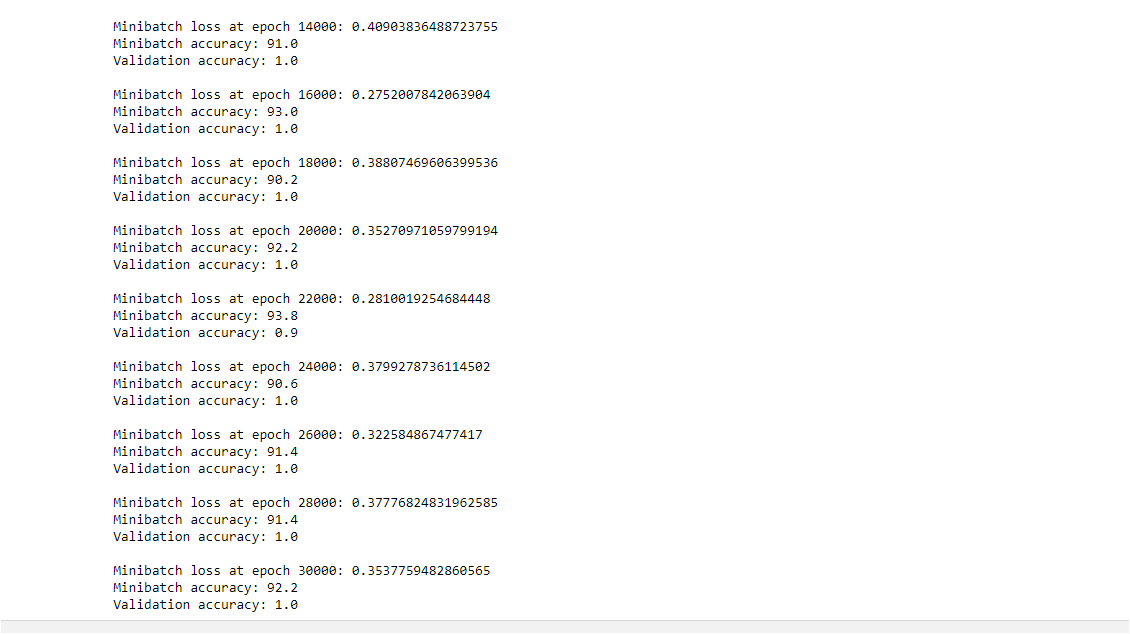

#### running dense NN with

- graph as graph1
- with drop out prob = 0.5
- start_learning_rate = 0.05
    decay_steps = 100000
    decay_rate = 0.96
    num_epochs = 30001
    batch_size = 256
    hidden_nodes = 1000
#### results are like following image. we see minibatch accuracy and validation accuracy are close, overfitting got under control, training slows down.
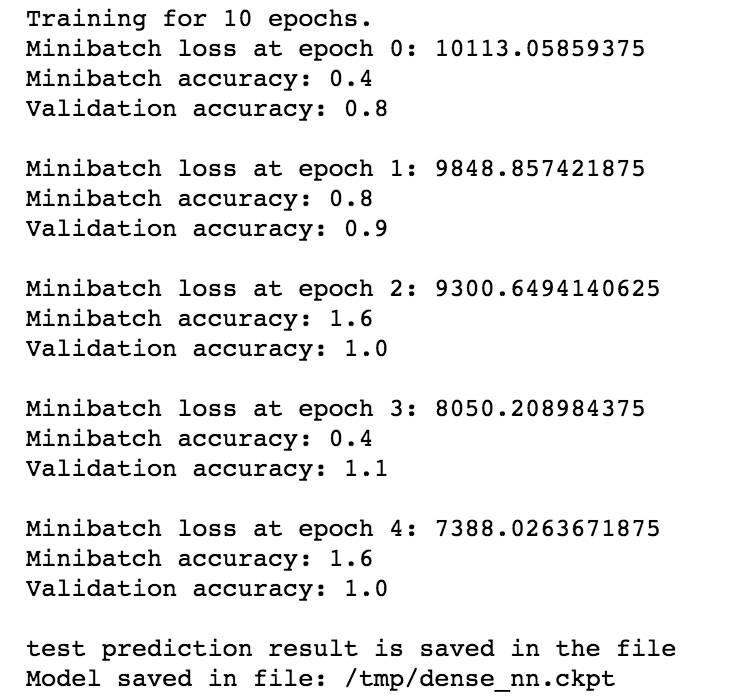


#### running dense NN with

- graph as graph1
- with drop out prob = 0.5
- with regularization lamda_reg = 0.001
- start_learning_rate = 0.05
    decay_steps = 100000
    decay_rate = 0.96
    num_epochs = 30001
    batch_size = 256
    hidden_nodes = 1000
#### results are like following image. we see minibatch accuracy and validation accuracy are close, overfitting got under control
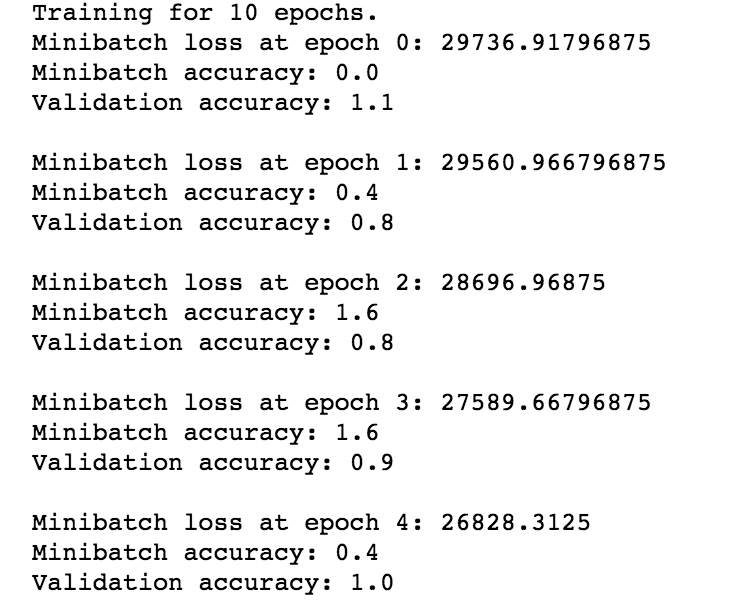


In [46]:
flattened_size = train_dataset.shape[1]

# use learning rate decay technique, with the epoch progressing, adjust learning rate
# tried start_learning_rate  as 0.5, 1
start_learning_rate = 0.01
decay_steps = 100000 
decay_rate = 0.96

# for regularization
lamb_reg = 0.001 

# keep probability : how much relu results we should keep
# effect: smaller number slows down learning process for training, increase validation set accuracy
# tried 0.5, 0.8, 1.0
k_prob = 0.5

# num of epochs, if running on aws use 20001, in local use 10,100
num_epochs = 20001
batch_size = 1000

# num of nodes in the first hidden layer 
# increase hidden nodes number slows down the processing speed
# didn't see the dramatic changes in 100 epoch run
# tried: 512, 1024
hidden_nodes = 1024

# num of hidden layers in NN model
layer_cnt = 5

# optimizer choice 1 ( GradientDescentOptimizer), 2 (AdamOptimizer), 3 (MomentumOptimizer)
opt_choice = 2

#### try num_epochs = 20001, opt_choice = 2, k_prob = 0.5, start_learning_rate = 0.01, hidden_nodes = 1024

In [47]:
reset_graph()
tf_deep_nn("nn_multiple_layer_5", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 5
hidden node number is 1024
start_learning_rate is 0.01
regularization is True and parameter is 0.001
drop out parameter is 0.5
run 1000 batch size
optimizer is using AdamOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 1024
calculating weights1,biases1 and hidden_cur_cnt is 512
calculating weights2,biases2 and hidden_cur_cnt is 256
Training for 20001 epochs.
Minibatch loss at epoch 0: 4.787693500518799
Minibatch accuracy: 0.3
Validation accuracy: 1.1

Minibatch loss at epoch 2000: 4.492616653442383
Minibatch accuracy: 2.4
Validation accuracy: 0.7

Minibatch loss at epoch 4000: 3.1023733615875244
Minibatch accuracy: 22.8
Validation accuracy: 1.7

Minibatch loss at epoch 6000: 1.8493688106536865
Minibatch accuracy: 56.8
Validation accuracy: 1.7

Minibatch loss at epoch 8000: 1.2651619911193848
Minibatch accuracy: 74.5
Validation accuracy: 1.5

Minibatch loss at epoch 10000: 1.0660150051116943
Minibatch accuracy: 81.9
Validation accuracy: 1.7

Minibatch loss a

#### try num_epochs = 20001, opt_choice = 2, k_prob = 0.5, start_learning_rate = 0.01

In [75]:
reset_graph()
tf_deep_nn("nn_multiple_layer_5", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 5
hidden node number is 512
start_learning_rate is 0.01
regularization is True and parameter is 0.001
drop out parameter is 0.5
run 1000 batch size
optimizer is using AdamOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
calculating weights2,biases2 and hidden_cur_cnt is 128
Training for 20001 epochs.
Minibatch loss at epoch 0: 4.78759241104126
Minibatch accuracy: 0.3
Validation accuracy: 1.3

Minibatch loss at epoch 2000: 4.176703929901123
Minibatch accuracy: 4.4
Validation accuracy: 0.9

Minibatch loss at epoch 4000: 3.604630470275879
Minibatch accuracy: 11.4
Validation accuracy: 1.3

Minibatch loss at epoch 6000: 2.370901107788086
Minibatch accuracy: 34.0
Validation accuracy: 1.3

Minibatch loss at epoch 8000: 1.890742540359497
Minibatch accuracy: 50.6
Validation accuracy: 1.5

Minibatch loss at epoch 10000: 1.6814935207366943
Minibatch accuracy: 59.9
Validation accuracy: 1.7

Minibatch loss at epoc

#### try num_epochs = 6001, opt_choice = 2, k_prob = 0.5, start_learning_rate = 0.01

In [64]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 0.01
regularization is True and parameter is 0.001
drop out parameter is 0.5
run 1000 batch size
optimizer is using AdamOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 6001 epochs.
Minibatch loss at epoch 0: 4.78759241104126
Minibatch accuracy: 0.3
Validation accuracy: 1.0

Minibatch loss at epoch 2000: 3.052212715148926
Minibatch accuracy: 19.7
Validation accuracy: 1.4

Minibatch loss at epoch 4000: 1.881367802619934
Minibatch accuracy: 52.7
Validation accuracy: 1.7

Minibatch loss at epoch 6000: 1.326146125793457
Minibatch accuracy: 67.8
Validation accuracy: 1.5

test prediction result is saved in the file
Model saved in file: /tmp/nn_multiple_layer_4.ckpt


#### try num_epochs = 6001, opt_choice = 2, k_prob = 0.5, start_learning_rate = 0.1

In [57]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 0.1
regularization is True and parameter is 0.001
drop out parameter is 0.5
run 1000 batch size
optimizer is using AdamOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 6001 epochs.
Minibatch loss at epoch 0: 4.78759241104126
Minibatch accuracy: 0.3
Validation accuracy: 1.0

Minibatch loss at epoch 2000: 3.0223166942596436
Minibatch accuracy: 18.1
Validation accuracy: 1.9

Minibatch loss at epoch 4000: 1.8461145162582397
Minibatch accuracy: 53.4
Validation accuracy: 1.7

Minibatch loss at epoch 6000: 1.5051263570785522
Minibatch accuracy: 65.4
Validation accuracy: 1.6

test prediction result is saved in the file
Model saved in file: /tmp/nn_multiple_layer_4.ckpt


#### try num_epochs = 6001, opt_choice = 2, k_prob = 0.5

In [55]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 1.0
regularization is True and parameter is 0.001
drop out parameter is 0.5
run 1000 batch size
optimizer is using AdamOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 6001 epochs.
Minibatch loss at epoch 0: 4.78759241104126
Minibatch accuracy: 0.3
Validation accuracy: 1.0

Minibatch loss at epoch 2000: 2.539092540740967
Minibatch accuracy: 30.8
Validation accuracy: 1.3

Minibatch loss at epoch 4000: 1.2916114330291748
Minibatch accuracy: 69.7
Validation accuracy: 1.6

Minibatch loss at epoch 6000: 1.0537220239639282
Minibatch accuracy: 77.5
Validation accuracy: 1.8

test prediction result is saved in the file
Model saved in file: /tmp/nn_multiple_layer_4.ckpt


#### try num_epochs = 6001, opt_choice = 2, k_prob = 0.8

In [51]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 1.0
regularization is True and parameter is 0.001
drop out parameter is 0.8
run 1000 batch size
optimizer is using AdamOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 6001 epochs.
Minibatch loss at epoch 0: 4.787591934204102
Minibatch accuracy: 0.3
Validation accuracy: 1.0

Minibatch loss at epoch 2000: 1.8571323156356812
Minibatch accuracy: 53.3
Validation accuracy: 1.2

Minibatch loss at epoch 4000: 0.6475249528884888
Minibatch accuracy: 87.4
Validation accuracy: 1.7

Minibatch loss at epoch 6000: 0.4579201340675354
Minibatch accuracy: 91.9
Validation accuracy: 1.5

test prediction result is saved in the file
Model saved in file: /tmp/nn_multiple_layer_4.ckpt


#### try num_epochs = 8001, opt_choice = 2, k_prob = 1.0

In [49]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 1.0
regularization is True and parameter is 0.001
drop out parameter is 1.0
run 1000 batch size
optimizer is using AdamOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 8001 epochs.
Minibatch loss at epoch 0: 4.787591934204102
Minibatch accuracy: 0.3
Validation accuracy: 1.0

Minibatch loss at epoch 2000: 2.700164318084717
Minibatch accuracy: 29.3
Validation accuracy: 1.3

Minibatch loss at epoch 4000: 0.5450639724731445
Minibatch accuracy: 92.8
Validation accuracy: 1.2

Minibatch loss at epoch 6000: 0.2332870066165924
Minibatch accuracy: 98.5
Validation accuracy: 1.4

Minibatch loss at epoch 8000: 0.22868016362190247
Minibatch accuracy: 99.0
Validation accuracy: 1.4

test prediction result is saved in the file
Model saved in file: /tmp/nn_multiple_layer_4.ckpt


#### try num_epochs = 20001, opt_choice = 1, k_prob = 0.8

In [45]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 1.0
regularization is True and parameter is 0.001
drop out parameter is 0.8
run 1000 batch size
optimizer is using GradientDescentOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 20001 epochs.
Minibatch loss at epoch 0: 4.787591934204102
Minibatch accuracy: 0.3
Validation accuracy: 0.9

Minibatch loss at epoch 2000: 4.785061836242676
Minibatch accuracy: 1.4
Validation accuracy: 1.0

Minibatch loss at epoch 4000: 4.7837443351745605
Minibatch accuracy: 1.5
Validation accuracy: 1.0

Minibatch loss at epoch 6000: 4.786581516265869
Minibatch accuracy: 1.3
Validation accuracy: 1.0

Minibatch loss at epoch 8000: 4.785696506500244
Minibatch accuracy: 1.5
Validation accuracy: 1.0

Minibatch loss at epoch 10000: 4.785031795501709
Minibatch accuracy: 1.5
Validation accuracy: 1.0

Minibatch loss at epoch 12000: 4.7844109535217285
Minibatch accuracy: 

#### try num_epochs = 20001, opt_choice = 1, k_prob = 0.5

In [47]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 1.0
regularization is True and parameter is 0.001
drop out parameter is 0.5
run 1000 batch size
optimizer is using GradientDescentOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 20001 epochs.
Minibatch loss at epoch 0: 4.787591934204102
Minibatch accuracy: 0.3
Validation accuracy: 0.9

Minibatch loss at epoch 2000: 4.785061836242676
Minibatch accuracy: 1.4
Validation accuracy: 1.0

Minibatch loss at epoch 4000: 4.7837443351745605
Minibatch accuracy: 1.5
Validation accuracy: 1.0

Minibatch loss at epoch 6000: 4.786581516265869
Minibatch accuracy: 1.3
Validation accuracy: 1.0

Minibatch loss at epoch 8000: 4.785697937011719
Minibatch accuracy: 1.5
Validation accuracy: 1.0

Minibatch loss at epoch 10000: 4.78503942489624
Minibatch accuracy: 1.5
Validation accuracy: 1.0

Minibatch loss at epoch 12000: 4.784488677978516
Minibatch accuracy: 1.

In [227]:
reset_graph()
tf_deep_nn("nn_multiple_layer_4", True, layer_cnt=layer_cnt, start_learning_rate = start_learning_rate)

model layer is 4
hidden node number is 512
start_learning_rate is 1.0
regularization is True and parameter is 0.001
drop out parameter is 0.8
run 1000 batch size
optimizer is using MomentumOptimizer
calculating weights0,biases0 and hidden_cur_cnt is 512
calculating weights1,biases1 and hidden_cur_cnt is 256
Training for 100 epochs.
Minibatch loss at epoch 0: 4.787585258483887
Minibatch accuracy: 1.1
Validation accuracy: 1.0

Minibatch loss at epoch 10: 4.778700828552246
Minibatch accuracy: 2.1
Validation accuracy: 1.0

Minibatch loss at epoch 20: 4.776041507720947
Minibatch accuracy: 1.4
Validation accuracy: 1.0

Minibatch loss at epoch 30: 4.777792453765869
Minibatch accuracy: 0.9
Validation accuracy: 1.0

Minibatch loss at epoch 40: 4.769383430480957
Minibatch accuracy: 2.0
Validation accuracy: 1.0

Minibatch loss at epoch 50: 4.778604030609131
Minibatch accuracy: 1.5
Validation accuracy: 1.0

Minibatch loss at epoch 60: 4.772200584411621
Minibatch accuracy: 1.1
Validation accuracy: 

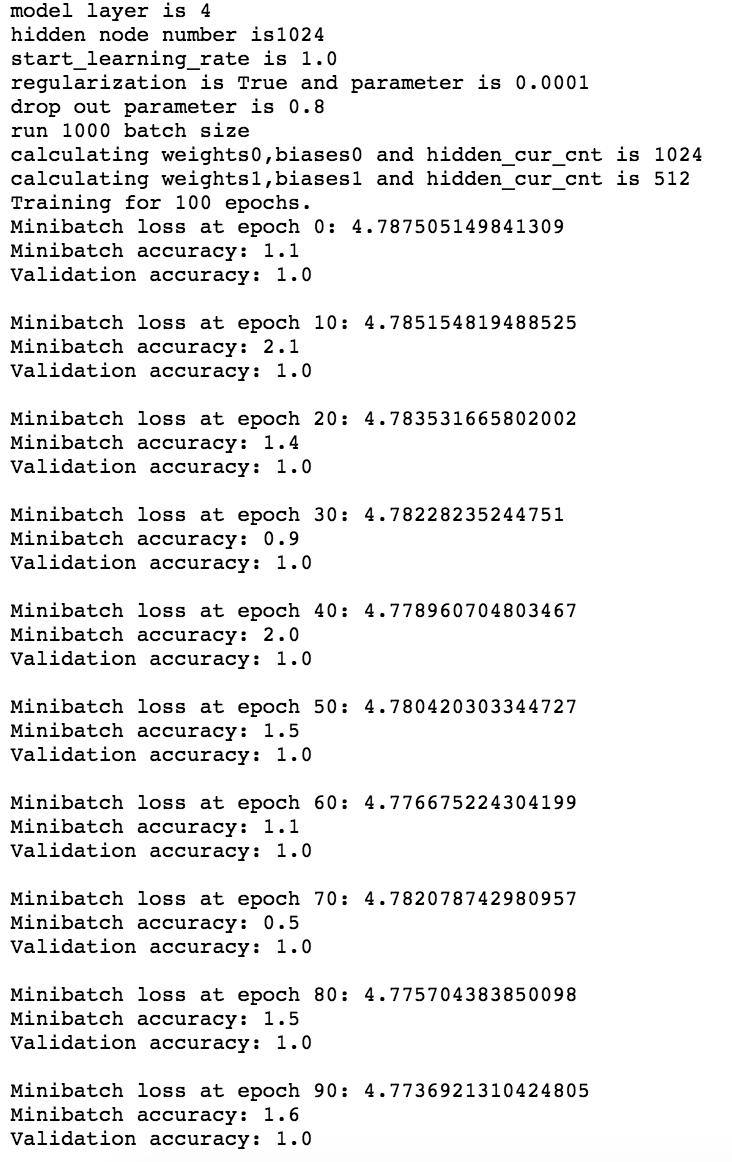

In [48]:
test_labels_ravel = pd.read_csv('/tmp/test_results.csv')
print(test_labels_ravel.head(2))
test_labels_onehot = np.array(test_labels_ravel['ravel_col'].reset_index(drop = True)).reshape((-1, num_labels)).astype(np.float32)
print(test_labels_onehot[0:2])
print(test_labels_onehot.shape)
labels = build_submission_file(test_labels_onehot)
labels.head(4)

   Unnamed: 0     ravel_col
0           0  3.560955e-06
1           1  3.566775e-07
[[  3.56095484e-06   3.56677475e-07   4.01911166e-07   5.92866728e-11
    9.86161597e-10   4.37333711e-06   5.63989788e-09   3.24227367e-10
    1.91734600e-07   8.05111995e-06   1.66157164e-07   9.51460091e-11
    1.02992337e-04   1.09133300e-14   3.15851700e-09   8.78310232e-07
    3.45594754e-06   6.95511120e-15   9.00622617e-05   6.32949906e-08
    3.04644322e-03   1.68168810e-13   3.57255288e-14   2.01707271e-12
    7.72860997e-10   2.04419069e-13   1.59818041e-14   3.88810928e-10
    4.17442643e-11   2.30274328e-12   2.71112800e-15   7.06662684e-09
    1.41283891e-07   1.32849370e-10   9.12979071e-04   8.95332545e-15
    1.00402102e-13   2.95615881e-13   2.72453504e-10   1.42466028e-09
    5.68626743e-13   1.13095320e-08   1.55247506e-06   4.36269998e-09
    1.21007403e-07   1.16199279e-10   6.28605168e-09   2.57963802e-05
    8.25850610e-10   6.87086347e-13   1.21802586e-05   7.71750663e-09
    1.

,breed,id
0,breed_irish_water_spaniel,fd1a7be32f10493735555e62913c0841
1,breed_shih-tzu,5273d42f02b4715cb93845205995ef64
2,breed_saluki,442057a3142f4d75a1023db363e2fb54
3,breed_redbone,fb03302b030afd122e0f4936c158f6c1


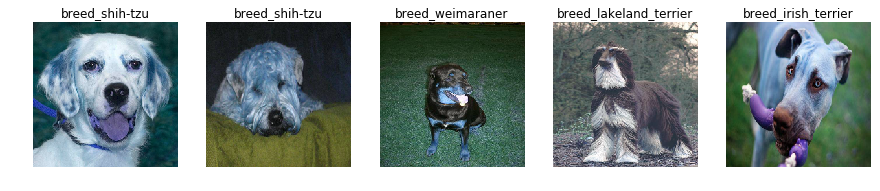

In [49]:
plot_strip(test_images,  np.array(labels.iloc[labels.index]['breed']))

In [50]:
labels['breed'].unique()

array(['breed_irish_water_spaniel', 'breed_shih-tzu', 'breed_saluki',
       'breed_redbone', 'breed_basset', 'breed_border_collie',
       'breed_kuvasz', 'breed_chihuahua', 'breed_bedlington_terrier',
       'breed_tibetan_mastiff', 'breed_schipperke', 'breed_keeshond',
       'breed_appenzeller', 'breed_rottweiler', 'breed_sealyham_terrier',
       'breed_clumber', 'breed_basenji',
       'breed_greater_swiss_mountain_dog', 'breed_toy_poodle',
       'breed_whippet', 'breed_irish_terrier', 'breed_rhodesian_ridgeback',
       'breed_norwegian_elkhound', 'breed_english_setter',
       'breed_australian_terrier', 'breed_samoyed', 'breed_briard',
       'breed_french_bulldog', 'breed_kerry_blue_terrier', 'breed_pug',
       'breed_dandie_dinmont', 'breed_standard_schnauzer', 'breed_cairn',
       'breed_collie', 'breed_weimaraner', 'breed_bernese_mountain_dog',
       'breed_bouvier_des_flandres', 'breed_west_highland_white_terrier',
       'breed_maltese_dog', 'breed_affenpinscher',
  

In [ ]:
# the following code is to retrieve test results from the saved file and apply build_submission_file_predict_prob func
# to build up the submission file
num_labels = 120
float_formatter = lambda x: "%.9f" % x

test_labels_ravel = pd.read_csv('test_results.csv')
print(test_labels_ravel.head(2))

test_labels_onehot = np.array(test_labels_ravel['ravel_col'].reset_index(drop = True)).reshape((-1, num_labels)).astype(np.float32)
#predict_prob = np.array2string(test_labels_onehot, formatter={'float_kind':'{0:.9f}'.format})
#print(predict_prob)
print(test_labels_onehot.shape)
labels = build_submission_file_predict_prob(test_labels_onehot)
# add one line to remove 'breed_' in column name
labels.columns = labels.columns.str.replace("breed_", "")
labels.head(4)

In [53]:
labels.to_csv('/tmp/labels_test.csv')